# Variational Autoencoders - MNIST

## 1. Importing libraries

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

import time

## 2. Setting Hyperparameters

In [ ]:
# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50
NUM_WORKERS = 1


Device: cuda


## 3. Loading Data

In [ ]:
# Define the transformation to convert images to PyTorch tensors
train_transform = transforms.ToTensor()

# Create the MNIST dataset for training
train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transform,
                                   download=True)

# Create a data loader for efficient batch processing during training
train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 69838993.00it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4237291.65it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49493261.46it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6185236.61it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 8, 6, 2, 2, 4, 5, 3, 2, 2])


## 4. Data processing and Training

In [ ]:
# Define a module to reshape the input tensor to a specified shape
class Reshape(nn.Module):
    """
    Reshape the input tensor to a specified shape.

    Args:
        *args: Size arguments for reshaping the tensor.

    Example:
        Reshape(64, 14, 14)
    """
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

# Define a module to trim the input tensor to a specified size
class Trim(nn.Module):
    """
    Trim the input tensor to a specified size.

    Example:
        Trim()  # Trims the tensor to (1, 28, 28)
    """
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

# Define a Variational Autoencoder (VAE) module
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) module.

    Example:
        vae = VAE()
    """
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                nn.ReLU(),
                nn.Flatten(),
                torch.nn.Linear(12544, 32),
                nn.ReLU(),
        )

        self.z_mean = torch.nn.Linear(32, 2)
        self.z_log_var = torch.nn.Linear(32, 2)


        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 12544),
                Reshape(-1, 64, 14, 14),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        """
        Forward pass through the encoder layers to compute the encoded representation.

        Args:
            x: Input tensor.

        Returns:
            Encoded representation.
        """
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        """
        Reparameterization trick to sample from the learned distribution.

        Args:
            z_mu: Mean of the distribution.
            z_log_var: Log-variance of the distribution.

        Returns:
            Sampled latent vector.
        """
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        """
        Forward pass through the VAE.

        Args:
            x: Input tensor.

        Returns:
            Encoded representation, mean and log-variance of the latent distribution, and decoded output.
        """
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_vae_v1(num_epochs, model, optimizer, device,
                 train_loader, loss_fn=None,
                 logging_interval=100,
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    """
    Train a Variational Autoencoder (VAE) model.

    Args:
        num_epochs (int): Number of training epochs.
        model (nn.Module): VAE model to be trained.
        optimizer (torch.optim.Optimizer): Optimization algorithm.
        device (torch.device): Device to perform training on (e.g., 'cuda' or 'cpu').
        train_loader (DataLoader): DataLoader for the training dataset.
        loss_fn (callable, optional): Loss function for the reconstruction term. Defaults to F.mse_loss.
        logging_interval (int, optional): Interval for logging batch-wise training loss. Defaults to 100.
        skip_epoch_stats (bool, optional): Skip computing and logging epoch-wise statistics. Defaults to False.
        reconstruction_term_weight (float, optional): Weight for the reconstruction term in the loss. Defaults to 1.
        save_model (str, optional): File path to save the trained model. Defaults to None.

    Returns:
        dict: Dictionary containing training logs.
    """
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)

            # Calculate KL divergence
            kl_div = -0.5 * torch.sum(1 + z_log_var
                                      - z_mean**2
                                      - torch.exp(z_log_var),
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension

            # Calculate pixel-wise reconstruction loss
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension

            loss = reconstruction_term_weight*pixelwise + kl_div

            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [ ]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0235 | Loss: 173.4123
Epoch: 001/050 | Batch 0050/0235 | Loss: 59.9055
Epoch: 001/050 | Batch 0100/0235 | Loss: 55.0902
Epoch: 001/050 | Batch 0150/0235 | Loss: 51.3338
Epoch: 001/050 | Batch 0200/0235 | Loss: 50.6386
Time elapsed: 0.17 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 49.3092
Epoch: 002/050 | Batch 0050/0235 | Loss: 50.0738
Epoch: 002/050 | Batch 0100/0235 | Loss: 47.8094
Epoch: 002/050 | Batch 0150/0235 | Loss: 48.1765
Epoch: 002/050 | Batch 0200/0235 | Loss: 46.2825
Time elapsed: 0.30 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 46.9791
Epoch: 003/050 | Batch 0050/0235 | Loss: 46.6513
Epoch: 003/050 | Batch 0100/0235 | Loss: 46.1284
Epoch: 003/050 | Batch 0150/0235 | Loss: 44.9844
Epoch: 003/050 | Batch 0200/0235 | Loss: 44.4354
Time elapsed: 0.44 min
Epoch: 004/050 | Batch 0000/0235 | Loss: 44.8148
Epoch: 004/050 | Batch 0050/0235 | Loss: 43.8046
Epoch: 004/050 | Batch 0100/0235 | Loss: 44.6569
Epoch: 004/050 | Batch 0150/0235 | Loss: 44.5057

 ## 5. Saving and loading the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Saved_Models/VAE/checkpoint.pth')

In [ ]:
# state_dict = torch.load('/content/drive/MyDrive/Saved_Models/VAE/checkpoint.pth')
# model.load_state_dict(state_dict)

## 6. Model Testing

In [ ]:
import numpy as np

# Initialize empty lists to store final labels and encoded representations
final_labels = []
final_encoded = []

# Iterate through the training data loader
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(DEVICE)

        # Encode the images using the VAE model
        encoded = model.encoding_fn(images)

        # Convert PyTorch tensors to NumPy arrays
        encoded = encoded.cpu().detach().numpy()
        labels = labels.detach().numpy()

        # Concatenate labels and encoded representations to the final lists
        if len(final_labels) == 0:
            final_labels = labels
            final_encoded = encoded
        else:
            final_labels = np.concatenate((final_labels, labels))
            final_encoded = np.concatenate((final_encoded, encoded), axis=0)

### 6.1 Checking the latent space for different digits

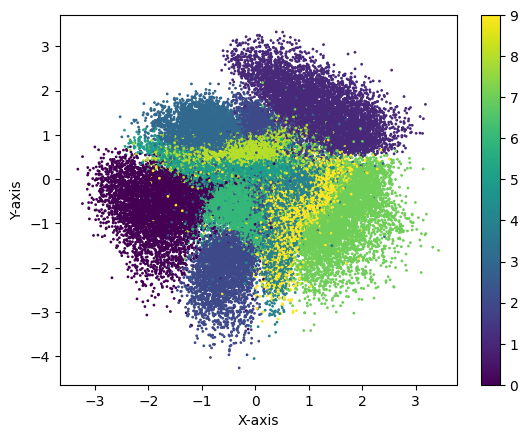

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(final_encoded[:, 0], final_encoded[:, 1], c=final_labels, cmap='viridis', s=1)

# Add colorbar to show label-color mapping
plt.colorbar()

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

### 6.2 Trying to pass different coordinates of the latent space to the decoder

#### 6.2.1 Trying with known points in the latent space

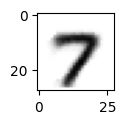

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.0, -1.0]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.figure(figsize=(1, 1))
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()


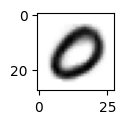

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-2.0, -1.0]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.figure(figsize=(1, 1))
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()


#### 6.2.2 Trying with an arbitrary point

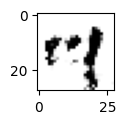

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.0, -10.0]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.figure(figsize=(1, 1))
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()
